<a href="https://colab.research.google.com/github/IsaacFigNewton/Text-to-Timeline/blob/main/Combining_Timeline_Generation_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Packages

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Broken libraries I've tried: AllenNLP, Coreferee, neuralcoref, spacy-experimental, stanford-corenlp (only api available)
!pip install fastcoref
!pip install intervaltree
!pip install rdflib flufl.enum

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/IsaacFigNewton/Text-to-Timeline.git
!wget https://raw.githubusercontent.com/IsaacFigNewton/fredlib-updated/refs/heads/main/fredlib.py

Cloning into 'Text-to-Timeline'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 9), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 76.81 KiB | 696.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.
--2025-05-12 05:16:41--  https://raw.githubusercontent.com/IsaacFigNewton/fredlib-updated/refs/heads/main/fredlib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36975 (36K) [text/plain]
Saving to: ‘fredlib.py’

fredlib.py          100%[===================>]  36.11K  --.-KB/s    in 0.05s   

2025-05-12 05:16:42 (701 KB/s) - ‘fredlib.py’ saved [36975/36975]



# Import Libraries

In [4]:
import sys
import os
import json
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
import math
import string
import numpy as np
import requests
import json
import pandas as pd
import collections
import pprint

import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

import fredlib as fred
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph

from collections import defaultdict, deque
from intervaltree import IntervalTree
from intervaltree import Interval as ITInterval

from nltk.corpus import stopwords
from fastcoref import FCoref, spacy_component

In [6]:
# Add the timeline reconstruction modules directory to the Python path
module_path = os.path.abspath('./Text-to-Timeline/modules')
if module_path not in sys.path:
    sys.path.append(module_path)

from pipeline import *
from utils import plot_graph_from_edge_list
from fastcoref_coref_resolution import resolve_text

In [7]:
from google.colab import userdata
fred_api_key = userdata.get("fred_api")

In [8]:
file_prefix = "test_"
rdf_temp_prefix = "boxer.owl: temp_"
tests = dict()
stop_words = stopwords.words('english')

# Config

In [9]:
default_nlp_model = spacy.load("en_core_web_sm")

fastcoref_model = FCoref()

coref_resolution_model = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
coref_resolution_model.add_pipe("fastcoref")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

In [10]:
tests = [
    "The frog jumped over the goose. Mr. Holmes is gay. Then the frog fell into the abyss. The goose followed the frog into the abyss and after that ate a different frog.",
    # "Although he was very busy with his work, Peter had had enough of it. He and his wife decided they needed a holiday. They travelled to Spain because they loved the country very much.",
    # "John met Paul after he finished work. He suggested they grab a drink.",
    # "The book was on the table when Sarah handed it to Mary. She smiled and thanked her.",
    # "Tom told Jerry that he had failed the exam.",
    # "The city council refused the demonstrators a permit because they feared violence.",
    # "Anna told Lucy that her idea was brilliant.",
    # "The scientist interviewed the assistant while she was setting up the experiment.",
    # "After the dog bit the man, he ran away.",
    # "The mechanic fixed the car while it was raining. He was soaked by the end.",
    # "David thanked Michael after his birthday party.",
    # "Karen lent her book to Julie because she needed it for class."
]

In [11]:
default_nlp_model = spacy.load("en_core_web_sm")

fastcoref_model = FCoref()

coref_resolution_model = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
coref_resolution_model.add_pipe("fastcoref")

### RDF Reduction Maps

In [12]:
rel_pos_tags = [
    ('before', 'start'),
    ('sameTimeAs', 'start'),
    ('sameTimeAs', 'end'),
    ('after', 'end'),
    ('during', None)
]

# each relation ==> (index into rel_pos_tags to use for "start",
#                  index into rel_pos_tags to use for "end")
temporal_relations_map = {
    # Main relations
    #    end of T1 before beginning of T2; start & end both “before start”
    "intervalBefore":       (0, 0),
    #    beginning of T1 is before T2’s start; end of T1 coincides with T2’s start
    "intervalMeets":        (0, 1),
    #    T1's start >= T2's start and T1's end <= T2's end
    # WARNING: info loss due to ambiguity removal
    "intervalIn":           (4, 4),
    #    start of T1 before T2’s start; end of T1 lies inside T2
    "intervalOverlaps":     (0, 4),
    #    both start and end of T1 lie inside T2
    "intervalDuring":       (4, 4),
    #    start of T1 = start of T2; end of T1 lies inside T2
    "intervalStarts":       (1, 4),
    #    start of T1 lies inside T2; end of T1 = end of T2
    "intervalFinishes":     (4, 2),
    #    both start and end of T1 coincide with T2
    "intervalEquals":       (1, 2),

    # Inverses
    #    start of T1 after end of T2  ⇒  start & end both “after end”
    "intervalAfter":        (3, 3),
    #    start of T1 = end of T2; end of T1 after end of T2
    "intervalMetBy":        (2, 3),
    #     start of T1 lies inside T2; end of T1 after T2’s end
    "intervalOverlappedBy": (4, 3),
    #     start of T1 before T2’s start; end of T1 after T2’s end
    "intervalContains":     (0, 3),
    #     start of T1 = start of T2; end of T1 after T2’s end
    "intervalStartedBy":    (1, 3),
    #     start of T1 before T2’s start; end of T1 = end of T2
    "intervalFinishedBy":   (0, 2),

    # instant relations
    "before":       (0, 0),
    "after":        (3, 3),
    "inside":       (4, 4),
    "hasBeginning": (1, None),
    "hasEnd":       (None, 2),
}

TEMPORAL_PREDICATE_MAP = {
    # "later" and synonyms → event A happens before event B
    "afterwards":        "intervalAfter",
    "subsequently":      "intervalAfter",
    "later":             "intervalAfter",
    "just_after":        "intervalAfter",
    "immediately after": "intervalAfter",

    # "earlier"and synonyms → event A happens before event B
    "then":               "intervalBefore",
    "earlier":            "intervalBefore",
    "previously":         "intervalBefore",
    "prior_to":           "intervalBefore",
    "immediately_before": "intervalBefore",

    # Overlap/containment
    "during":        "intervalDuring",
    "while":         "intervalDuring",
    "when":          "intervalDuring",
    "included":      "intervalContains",
    "contains":      "intervalContains",
    "encloses":      "intervalContains",
    "overlaps":      "intervalOverlap",
    "overlapping":   "intervalOverlap",

    # Meeting (end-to-start adjacency)
    "meets":         "intervalMeets",
    "met_by":        "intervalMetBy",

    # Start/finish relations
    "starts":        "intervalStarts",
    "ends":          "intervalEnds",
    "finishes":      "intervalFinishes",

    # Equality / simultaneity
    "simultaneous":    "instantEquals",
    "concurrent":      "instantEquals",
}

# Helper functions

In [13]:
def murder_orphans(g):
  # prune orphan nodes
  for node in list(g.nodes()):
    if g.degree(node) == 0:
      g.remove_node(node)

def complete_rel_from_partial_match(label:str, relations:set):
  for k in relations:
    if k in label:
      return add_rel_prefix(k)
  return label

def add_rel_prefix(rel:str, prefix:str=rdf_temp_prefix):
  return f"{prefix}{rel}"

def remove_rel_prefix(rel:str, prefix:str=rdf_temp_prefix):
  return rel.replace(prefix, "")

def get_fred_nx_digraph(text:str, path:str):
  fred_graph = fred.getFredGraph(
      text=text,
      key=fred_api_key,
      filename=path,
      prefix="fred:",
      namespace="http://www.ontologydesignpatterns.org/ont/fred/domain.owl#",
      wsd=False,
      wfd=True,
      wfd_profile='b',
      tense=True,
      roles=True,
      textannotation="earmark",
      semantic_subgraph=True,
      response_format="application/rdf+xml"
    )

  # Load RDF graph
  g = RDFGraph()
  g.parse(path, format='xml')
  print("rdflib Graph loaded successfully with {} triples".format(len(g)))

  return fred.get_simplified_nx_graph(g)

def list_nodes(g, drop_prefix:bool=False):
  if drop_prefix:
    return [node.split(" ")[-1] for node, _ in list(g.nodes(data=True))]
  else:
    return [node for node, _ in list(g.nodes(data=True))]

def list_triples(g, drop_prefix:bool=False):
  triples = list(g.edges(data=True))

  if drop_prefix:
    triples = [
        (
            subject.split(" ")[-1],
            predicate["labels"].split(" ")[-1],
            object1.split(" ")[-1]
        ) for subject, object1, predicate in triples
    ]

  else:
    triples = [
        (
            subject,
            predicate["labels"],
            object1
        )
        for subject, object1, predicate in triples
    ]

  return triples

In [14]:
# A -type_to_split-> B -other_type-> C
# will be propagated such that
# A -other_type-> C
# and B is removed

# propagate entity types to simplify event descriptions
def propagate_types(g):
  # set of RDF entity type nodes
  type_nodes = set()

  for edge in list(g.edges(data=True)):
    if edge[2]["labels"] == '22-rdf-syntax-ns: type':
      # add the type node to the set
      type_nodes.add(edge[1])

      # for each outgoing edge from the type node (B)
      for type_edge in list(g.edges(edge[1], data=True)):
        # add a copy of the edge between the original source node (A)
        #   and the new target node (C)
        g.add_edge(edge[0], type_edge[1], labels=type_edge[2]["labels"])

      # remove the type edge from the graph
      g.remove_edge(edge[0], edge[1])
      # add the type property to the original source node
      nx.set_node_attributes(g, {edge[0]: edge[1]}, "type")

  # prune RDF entity type nodes
  for node in type_nodes:
    g.remove_node(node)


def prune_subgraph_types(g,
                    node_types_to_drop:set,
                    edge_types_to_drop:set):
  # drop nodes of a certain type
  for node in list(g.nodes):
    for keyword in node_types_to_drop:
      if keyword in node:
        g.remove_node(node)

  # prune redundant edges
  for edge in list(g.edges(data=True)):
    if edge[2]["labels"] in edge_types_to_drop:
      g.remove_edge(edge[0], edge[1])

  # prune orphan nodes
  murder_orphans(g)



def disambiguate_predicate(e):
  for k, v in TEMPORAL_PREDICATE_MAP.items():
    if k in e[2]["labels"]:
      print(k)
      return v
  return e[2]["labels"]


def disambiguate_predicates(g):
  cleaned_edges = list()

  for e in g.edges(data=True):
    if "temp_" in e[2]["labels"]:
      print(e)

      cleaned_edges.append((
        e[0],
        e[1],
        {"labels": add_rel_prefix(disambiguate_predicate(e))}
      ))

  new_g = nx.DiGraph()
  new_g.add_edges_from(cleaned_edges)
  return new_g

In [15]:
def run_tests(texts:str):
  ambiguated_texts = [[t, None] for t in texts]
  ambiguated_test = None

  for i in range(len(texts)):
    _, ambiguated_test = ambiguate_text(texts[i])
    ambiguated_texts[i][1] = ambiguated_test

  for test in ambiguated_texts:
    print(f"original:\n{test[0]}")
    print(f"disambiguated:\n{test[1]}")
    # print()

## Timeline Construction Helpers

In [26]:
# Apply a single rel_pos_tag between a source boundary and a target event
def apply_tag(tag, source, target_event, graph, dsu):
    rel, boundRef = tag

    # get target boundary if boundRef specified
    if rel == 'sameTimeAs':
        # unify source with target boundary
        target = target_event.start if boundRef == 'start' else target_event.end
        dsu.union(source, target)

    elif rel == 'before':
        target = target_event.start if boundRef == 'start' else target_event.end
        graph[source].add(target)

    elif rel == 'after':
        target = target_event.start if boundRef == 'start' else target_event.end
        graph[target].add(source)

    elif rel == 'during':
        # during: target_event.start -> source, and source_end -> target_event.end
        if source.kind == 'start':
            graph[target_event.start].add(source)
            # record containment
            target_event.children.append(source.event)
        else:
            graph[source].add(target_event.end)

    else:
        raise ValueError(f"Unknown relation {rel}")


# Main function to build timeline
def build_interval_timeline(event_names,
                            temporal_relations_input,
                            rel_pos_tags):
    # Create events
    events = {name: Event(name) for name in event_names}

    # DSU for boundary unification
    dsu = DSU()
    # graph edges: boundary -> set(boundary)
    graph = defaultdict(set)

    # Helper to add edge post-union normalization
    def add_edge(u, v):
        graph[u].add(v)

    print(json.dumps(temporal_relations_input, indent=4))

    # Process instant relations (single-boundary)
    for t1, rel_name, t2 in temporal_relations_input:
        e1, e2 = events[t1], events[t2]
        i_start, i_end = temporal_relations_map[remove_rel_prefix(rel_name)]
        # start mapping
        if i_start is not None:
            tag = rel_pos_tags[i_start]
            apply_tag(tag, e1.start, e2, graph, dsu)
        # end mapping
        if i_end is not None:
            tag = rel_pos_tags[i_end]
            apply_tag(tag, e1.end, e2, graph, dsu)

    # Ensure each event.start precedes event.end
    for e in events.values():
        graph[e.start].add(e.end)

    # Add global boundaries
    global_start = BoundaryNode(None, 'start')
    global_end = BoundaryNode(None, 'end')
    for e in events.values():
        if not any(e.start in graph[src] for src in graph):
            graph[global_start].add(e.start)
        if len(graph[e.end]) == 0:
            graph[e.end].add(global_end)

    # Consolidate DSU: rebuild nodes and edges on representatives
    rep_graph = defaultdict(set)
    for u, targets in graph.items():
        ru = dsu.find(u)
        for v in targets:
            rv = dsu.find(v)
            if ru != rv:
                rep_graph[ru].add(rv)
    # compute indegree
    indegree = defaultdict(int)
    for u, targets in rep_graph.items():
        indegree.setdefault(u, 0)
        for v in targets:
            indegree[v] += 1

    # Topological sort (Kahn)
    q = deque([node for node, deg in indegree.items() if deg == 0])
    topo = []
    while q:
        u = q.popleft()
        topo.append(u)
        for v in rep_graph[u]:
            indegree[v] -= 1
            if indegree[v] == 0:
                q.append(v)

    # Assign times
    time = 0
    for node in topo:
        node.time = time
        time += 1

    # Build pre-order on containment
    roots = [e for e in events.values() if not any(e in parent.children for parent in events.values())]

    ordered = []
    def preorder(e):
        ordered.append(e)
        for c in e.children:
            preorder(c)

    for r in roots:
        preorder(r)

    # Build the library’s IntervalTree
    tree = IntervalTree()
    for e in ordered:
        # print(e)

        # add interval [begin, end) with payload = the Event instance
        tree.addi(e.start.time, e.end.time, e.data)   # ← use library insertion :contentReference[oaicite:4]{index=4}

    return tree, events


def get_timeline(g, drop_event_edges:bool=True):
  temp_relations = [[e[0], e[2]["labels"], e[1]]
                          for e in g.edges(data=True)
                          if "temp_" in e[2]["labels"]]
  for t in temp_relations:
    print(t)

  # get all event nodes
  nodes = ({e[0] for e in temp_relations})\
          .union({e[2] for e in temp_relations})

  # drop event edges if desired
  if drop_event_edges:
    for e in temp_relations:
      try:
        g.remove_edge(e[0], e[2])
      except Exception as ex:
        print(ex)
        print(e)

  timeline, evs = build_interval_timeline(
      event_names=nodes,
      temporal_relations_input=temp_relations,
      rel_pos_tags=rel_pos_tags
  )

  return timeline

In [17]:
def print_interval_tree(tree):
  for interval in tree:
    print(f"Interval: {interval}")
    print(f"  Begin: {interval.begin}")
    print(f"  End: {interval.end}")
    print(f"  Data: {interval.data}")


def plot_interval_tree(tree:IntervalTree, grid:bool=True):
  # Prepare data
  intervals = sorted(tree)
  fig, ax = plt.subplots()

  for i, iv in enumerate(intervals):
    ax.broken_barh(
        [(iv.begin, iv.end - iv.begin)],
         (i - 0.4, 0.8),
        facecolors='tab:blue'
    )
    ax.text(
        (iv.begin + iv.end) / 2,
        i,
        iv.data.name.split(" ")[-1],
        ha='center',
        va='center',
        color='white'
    )

  ax.set_yticks(range(len(intervals)))
  ax.set_yticklabels([f"Interval {i+1}" for i in range(len(intervals))])
  ax.set_xlabel("Timeline")
  ax.set_title("IntervalTree Visualization")

  if grid:
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    # plt.grid(True)

  plt.tight_layout()
  plt.show()

# Utility

In [18]:
# Disjoint-set (Union-Find) for merging boundary nodes
class DSU:
    def __init__(self):
        self.parent = {}

    def find(self, x):
        if self.parent.setdefault(x, x) != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        rx, ry = self.find(x), self.find(y)
        if rx != ry:
            self.parent[ry] = rx

# Boundary node representing an event start/end
class BoundaryNode:
    def __init__(self, event, kind):  # kind: 'start' or 'end'
        self.event = event
        self.kind = kind
        self.time = None

    def __repr__(self):
        return f"{self.event.name}.{self.kind}" if self.event else f"Global.{self.kind}"

# Event with potential children (containment)
class Event:
    def __init__(self, name):
        self.name = name
        self.start = BoundaryNode(self, 'start')
        self.end = BoundaryNode(self, 'end')
        self.children = []

    def __str__(self):
        return f"{self.name}"

# Timeline Library Tests

In [19]:
test_infos = []
for test in tests:
  test_info = get_text_info_json(text=test,
                                 nlp_model=default_nlp_model,
                                 fastcoref_model=fastcoref_model,
                                 coref_resolution_model=coref_resolution_model)
  test_infos.append(test_info)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

/content/Text-to-Timeline/modules/utils.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


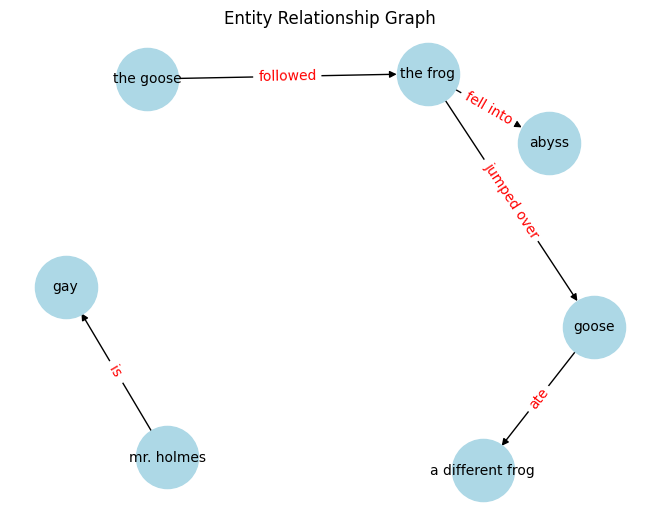

In [20]:
plot_graph_from_edge_list(test_infos[0]["edges"])

In [21]:
test_infos[0]["ambiguated"]

'E0 jumped over E1. Mr. Holmes is gay. Then E0 fell into E2. E1 followed E0 into E2 and after that ate a different frog.'

# Combined Tests

In [22]:
test_0 = resolve_text(
    tests[0],
    coref_resolution_model=coref_resolution_model
)
G0 = get_fred_nx_digraph(test_0, "test_0.rdf")
propagate_types(G0)

prune_subgraph_types(
    g=G0,
    node_types_to_drop={
      "org#ont#framenet#abox#frame:",
      "owl: Theme",
      "owl: Cotheme"
    },
    edge_types_to_drop={
      'owl: equivalentClass',
      'owl: hasDeterminer',
      'owl: differentFrom',
      'cotheme'
    }
)

G0 = disambiguate_predicates(G0)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

rdflib Graph loaded successfully with 50 triples
('domain.owl: Cotheme_1', 'domain.owl: frog_1', 'Cotheme.cotheme')
('domain.owl: Motion_directional_1', 'domain.owl: frog_1', 'Theme.motion_directional')
('domain.owl: situation_1', 'domain.owl: now_1', 'boxer.owl: temp_included')
('domain.owl: frog_1', 'domain.owl: Frog', '22-rdf-syntax-ns: type')
('domain.owl: abyss_1', 'quantifiers.owl: the', 'quantifiers.owl: hasDeterminer')
('domain.owl: frog_2', 'domain.owl: Frog', '22-rdf-syntax-ns: type')
('domain.owl: goose_1', 'quantifiers.owl: the', 'quantifiers.owl: hasDeterminer')
('domain.owl: Ingestion_1', 'domain.owl: now_1', 'boxer.owl: temp_before')
('domain.owl: Self_motion_1', 'domain.owl: Self_motion', '22-rdf-syntax-ns: type')
('domain.owl: Motion_directional_1', 'domain.owl: Ingestion_1', 'Oblique.motion_directional')
('domain.owl: frog_2', 'quantifiers.owl: a', 'quantifiers.owl: hasDeterminer')
('domain.owl: Motion_directional', 'DUL.owl: Event', 'rdf-schema: subClassOf')
('domain

['domain.owl: Motion_directional_1', 'boxer.owl: temp_boxer.owl: temp_before', 'domain.owl: now_1']
['domain.owl: situation_1', 'boxer.owl: temp_intervalContains', 'domain.owl: now_1']
['domain.owl: Ingestion_1', 'boxer.owl: temp_boxer.owl: temp_before', 'domain.owl: now_1']
['domain.owl: Self_motion_1', 'boxer.owl: temp_boxer.owl: temp_before', 'domain.owl: now_1']
[
    [
        "domain.owl: Motion_directional_1",
        "boxer.owl: temp_boxer.owl: temp_before",
        "domain.owl: now_1"
    ],
    [
        "domain.owl: situation_1",
        "boxer.owl: temp_intervalContains",
        "domain.owl: now_1"
    ],
    [
        "domain.owl: Ingestion_1",
        "boxer.owl: temp_boxer.owl: temp_before",
        "domain.owl: now_1"
    ],
    [
        "domain.owl: Self_motion_1",
        "boxer.owl: temp_boxer.owl: temp_before",
        "domain.owl: now_1"
    ]
]


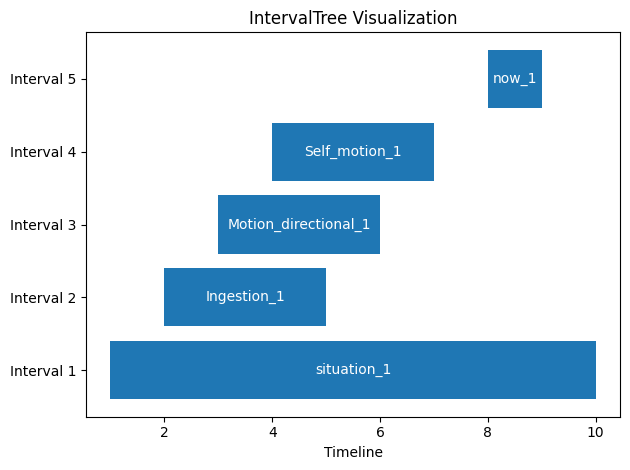

In [23]:
timeline = get_timeline(
    G0,
    drop_event_edges=False
)

plot_interval_tree(timeline, grid=False)

In [24]:
test_0

'The frog jumped over the goose. Mr. Holmes is gay. Then The frog fell into the abyss. the goose followed The frog into the abyss and after that ate a different frog.'